<a href="https://colab.research.google.com/github/shadab4150/Mura-Stanford-Bone-Xray-abnormalities-detection/blob/master/mura_stanford_bone_abnormalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import * 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange,tqdm
import gc

In [2]:
path = Path('/content/');path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/mura_xray'),
 PosixPath('/content/MURA-v1.1'),
 PosixPath('/content/final_mura_tr_vl.csv'),
 PosixPath('/content/mura_final_process.csv'),
 PosixPath('/content/drive'),
 PosixPath('/content/models'),
 PosixPath('/content/.ipynb_checkpoints'),
 PosixPath('/content/sample_data')]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/Dataset/MURA-v1.1.zip' -d '/content/'

# Preprocessing training set

In [0]:
tp = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv',sep='/',header=None)
tl = pd.read_csv('/content/MURA-v1.1/train_labeled_studies.csv',sep='/',header=None)

## This dataframe contains paths of training images

In [63]:
tp.head(3)

,0,1,2,3,4,5
0,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image1.png
1,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image2.png
2,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image3.png


## This dataframe contains label of training images

In [64]:
tl.head(3)

,0,1,2,3,4,5
0,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,",1"
1,MURA-v1.1,train,XR_SHOULDER,patient00002,study1_positive,",1"
2,MURA-v1.1,train,XR_SHOULDER,patient00003,study1_positive,",1"


## creating a single path columns from all columns

In [65]:
paths = []
for i in tnrange(tp.shape[0],desc='row'):
    p = "/".join(str(x) for x in tp.iloc[i].values)
    paths.append(p)

In [0]:
tp['path'] = paths

In [0]:
tp.columns = ['folder','set','body_part','patient_id','study_PN','image_id','path']
tl.columns = ['folder','set','body_part','patient_id','study_PN','target']

In [68]:
tp.head(2)

,folder,set,body_part,patient_id,study_PN,image_id,path
0,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...


In [72]:
tl.head(2)

,folder,set,body_part,patient_id,study_PN,target
0,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,1
1,MURA-v1.1,train,XR_SHOULDER,patient00002,study1_positive,1


In [0]:
def label(x):
    if x==',1':
        return 1
    elif x==',0':
        return 0

In [0]:
tl['target']=tl['target'].apply(label,convert_dtype=True)

* Merging both **path** and **target**

In [0]:
total = pd.merge(tp,tl,left_on=['folder','set','body_part','patient_id','study_PN'],right_on=['folder','set','body_part','patient_id','study_PN'],how='left')

## Creating one hot encoded for each body part

In [74]:
total_new = pd.get_dummies(total,columns=['body_part']);total_new.head()

,folder,set,patient_id,study_PN,image_id,path,target,body_part_XR_ELBOW,body_part_XR_FINGER,body_part_XR_FOREARM,body_part_XR_HAND,body_part_XR_HUMERUS,body_part_XR_SHOULDER,body_part_XR_WRIST
0,MURA-v1.1,train,patient00001,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
1,MURA-v1.1,train,patient00001,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
2,MURA-v1.1,train,patient00001,study1_positive,image3.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
3,MURA-v1.1,train,patient00002,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0
4,MURA-v1.1,train,patient00002,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0


# Preprocessing validation set

In [0]:
vp = pd.read_csv('/content/MURA-v1.1/valid_image_paths.csv',sep='/',header=None)  ## This dataframe contains paths of validation images
vl = pd.read_csv('/content/MURA-v1.1/valid_labeled_studies.csv',sep='/',header=None) ## This dataframe contains label of validation images

* Creating a single path columns from all columns

In [76]:
pathsv = []   
for i in tnrange(vp.shape[0],desc='row'):
    p = "/".join(str(x) for x in vp.iloc[i].values)
    pathsv.append(p)

In [0]:
vp['path'] = pathsv

In [0]:
vp.columns = ['folder','set','body_part','patient_id','study_PN','image_id','path']
vl.columns = ['folder','set','body_part','patient_id','study_PN','target']

In [0]:
vl['target']=vl['target'].apply(label,convert_dtype=True)

* Merging both **path** and **target**

In [0]:
totalv = pd.merge(vp,vl,left_on=['folder','set','body_part','patient_id','study_PN'],right_on=['folder','set','body_part','patient_id','study_PN'],how='left')

## Creating one hot encoded for each body part

In [81]:
totalv_new = pd.get_dummies(totalv,columns=['body_part']);totalv_new.head()

,folder,set,patient_id,study_PN,image_id,path,target,body_part_XR_ELBOW,body_part_XR_FINGER,body_part_XR_FOREARM,body_part_XR_HAND,body_part_XR_HUMERUS,body_part_XR_SHOULDER,body_part_XR_WRIST
0,MURA-v1.1,valid,patient11185,study1_positive,image1.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,0,0,0,0,0,0,1
1,MURA-v1.1,valid,patient11185,study1_positive,image2.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,0,0,0,0,0,0,1
2,MURA-v1.1,valid,patient11185,study1_positive,image3.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,0,0,0,0,0,0,1
3,MURA-v1.1,valid,patient11185,study1_positive,image4.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,0,0,0,0,0,0,1
4,MURA-v1.1,valid,patient11186,study1_positive,image1.png,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,0,0,0,0,0,0,1


# Final combining both Training and Validation into single dataframe

In [82]:
final = pd.concat([total_new,totalv_new]);final.head()

,folder,set,patient_id,study_PN,image_id,path,target,body_part_XR_ELBOW,body_part_XR_FINGER,body_part_XR_FOREARM,body_part_XR_HAND,body_part_XR_HUMERUS,body_part_XR_SHOULDER,body_part_XR_WRIST
0,MURA-v1.1,train,patient00001,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
1,MURA-v1.1,train,patient00001,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
2,MURA-v1.1,train,patient00001,study1_positive,image3.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
3,MURA-v1.1,train,patient00002,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0
4,MURA-v1.1,train,patient00002,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0


In [0]:
final.to_csv('final_mura_tr_vl.csv',index=False)

In [0]:
df = pd.read_csv('/content/final_mura_tr_vl.csv')

### Forming a validation set:
* As described in mura

In [0]:
def is_valid(x):
  if x=='train':
    return False
  elif x=='valid':
    return True

In [0]:
df.rename(columns={'set':'is_valid','target':'abnormal'},inplace=True);

In [0]:
df['is_valid'] = df['is_valid'].apply(is_valid,convert_dtype=True)

In [37]:
df.head()

,folder,is_valid,patient_id,study_PN,image_id,path,abnormal,body_part_XR_ELBOW,body_part_XR_FINGER,body_part_XR_FOREARM,body_part_XR_HAND,body_part_XR_HUMERUS,body_part_XR_SHOULDER,body_part_XR_WRIST
0,MURA-v1.1,False,patient00001,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
1,MURA-v1.1,False,patient00001,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
2,MURA-v1.1,False,patient00001,study1_positive,image3.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
3,MURA-v1.1,False,patient00002,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0
4,MURA-v1.1,False,patient00002,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0


In [0]:
cols = ['abnormal',
       'body_part_XR_ELBOW', 'body_part_XR_FINGER', 'body_part_XR_FOREARM',
       'body_part_XR_HAND', 'body_part_XR_HUMERUS', 'body_part_XR_SHOULDER',
       'body_part_XR_WRIST']

In [39]:
df['is_valid'].unique()

array([False,  True])

torch.Size([3, 512, 380])
------------------------------------------------------------


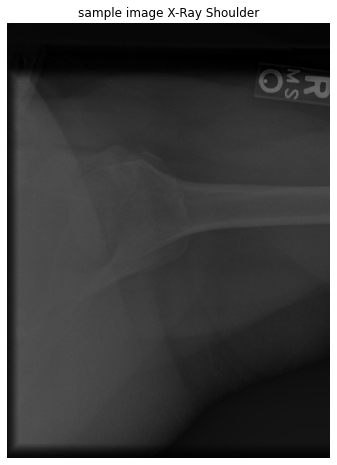

In [119]:
img =open_image(path/df.path.iloc[0])
print(img.shape)
print('--'*30)
img.show(figsize=(20,8),title='sample image X-Ray Shoulder')

In [0]:
tfms=get_transforms(do_flip=True)

In [0]:
data = (ImageList.from_df(df,path,cols='path',)
                .split_from_df(col='is_valid')
                .label_from_df(cols=cols,label_cls = MultiCategoryList, one_hot = True)
                .transform(size=256)
                .databunch(bs=128).normalize(imagenet_stats))

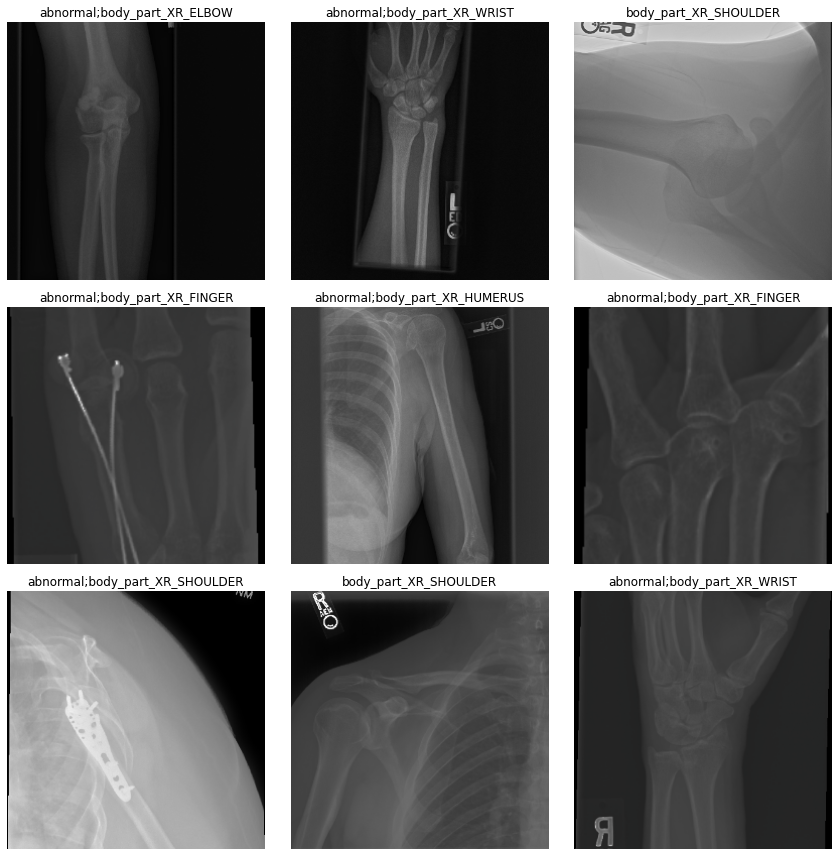

In [41]:
data.show_batch(rows=3)

In [14]:
data.classes,len(data.train_ds),len(data.valid_ds)

(['target',
  'body_part_XR_ELBOW',
  'body_part_XR_FINGER',
  'body_part_XR_FOREARM',
  'body_part_XR_HAND',
  'body_part_XR_HUMERUS',
  'body_part_XR_SHOULDER',
  'body_part_XR_WRIST'],
 36808,
 3197)

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [0]:
learn = cnn_learner(data, models.resnet18 , metrics = [acc_02, f_score] )

In [43]:
gc.collect()

13715

In [0]:
learn.lr_find()

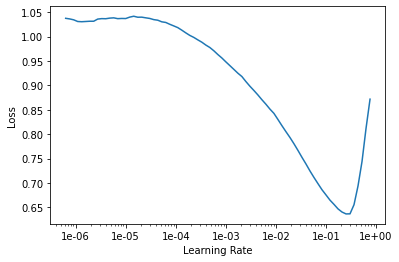

In [121]:
learn.recorder.plot()

In [44]:
gc.collect()

0

In [125]:
np.linspace(1e-2,1e-1,5)

array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ])

In [45]:
learn.fit_one_cycle(2 , 0.055 , moms=(0.8,0.7) )

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.135149,0.196755,0.895058,0.822307,05:48
1,0.091740,0.102969,0.946082,0.905476,05:36


In [0]:
learn.export('mura.pkl')

In [56]:
img = df[df['is_valid']==True].path.iloc[45];img
print(df[df['is_valid']==True].abnormal.iloc[45])

1


abnormal;body_part_XR_WRIST


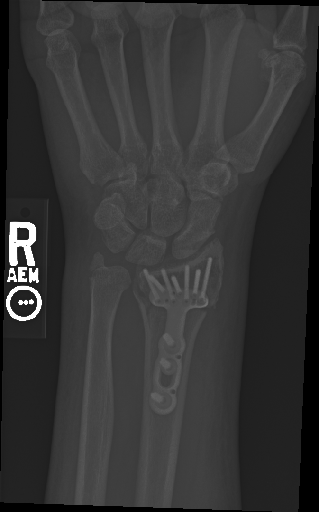

In [57]:
image = open_image(img)
print(learn.predict(image)[0])
image